#Text Classification Using SpaCy Word Embeddings

- We are going to address these problems using classical NLP techniques and going to classify whether a given message/ text is Real or Fake Message.

- We will use glove embeddings from spacy which is trained on massive wikipedia dataset to pre-process and text vectorization and apply different classification algorithms.

**Dataset**

Credits: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

- This data consists of two columns. - Text - label
- As there are only 2 classes, this problem comes under the **Binary Classification**.

In [ ]:
import pandas as pd

df = pd.read_csv('/content/Fake_Real_Data.csv')

df.shape

(9900, 2)

In [ ]:
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [ ]:
df['label'].value_counts()

,count
label,
Fake,5000
Real,4900


This dataset is almost equal number of classes distributed into Fake and Real so this dataset is balanced dataset so no need to apply balanced dataset technique like oversampling or undersampling etc.

In [ ]:
#adding new column and converting label column into num
df['label_num'] = df['label'].map({
    'Fake': 0,
    'Real': 1,
})

df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


- To import spacy word vectors we need to import medium or large model from spacy but here we are using large model because it comes with 343k unique vectors (300 dimensions) and medium comes with 20k unique vectors (300 dimensions).

- Getting spacy word vector and adding them into our dataset.

Downloading large english model from spacy

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [ ]:
#converting this doc or text into word vector
doc = nlp('Top Trump Surrogate BRUTALLY Stabs')

#printing dimensions of vector it will be 300
print(doc.vector.shape)

#printing first ten word vector values
doc.vector[:10]

(300,)


array([ 1.8258998,  0.536888 , -0.14478  ,  2.974568 ,  3.966114 ,
       -0.44674  , -0.1468199,  1.5710932, -1.9426501, -0.8065618],
      dtype=float32)

This is how we will convert text or doc into word vector

In [ ]:
#let's convert each row text into word vector form
df['vector'] = df['Text'].apply(lambda x: nlp(x).vector)

In [ ]:
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[-0.6759837, 1.4263071, -2.318466, -0.451093, ..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[-1.8355803, 1.3101058, -2.4919677, 1.0268308,..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[-1.9851209, 0.14389805, -2.4221718, 0.9133005..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[-2.7812982, -0.16120885, -1.609772, 1.3624227..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-2.2010763, 0.9961637, -2.4088492, 1.128273, ..."


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['vector'].values, df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num'])

In [ ]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ",  X_test.shape)

Shape of X_train:  (7920,)
Shape of X_test:  (1980,)


In [ ]:
X_train

Here in our training data we have ndarray which means we have numpy array but the every individual element is also numpy array so if we give this training dataset to our classifier it's excepting 2d numpy array so we need to convert this into convert training data into 2d numpy array.

In [ ]:
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [ ]:
X_train_2d

array([[-2.2457533 ,  0.65320826, -2.7725158 , ..., -0.6018606 ,
        -1.9761672 ,  1.2640717 ],
       [-2.0815852 ,  0.80192417, -1.6333157 , ..., -1.4228109 ,
        -2.0243683 ,  0.7941047 ],
       [-1.4317232 ,  0.9634989 , -2.395704  , ..., -0.5920523 ,
        -2.1728992 ,  1.4585347 ],
       ...,
       [-1.1563656 ,  0.5925829 , -2.0635247 , ..., -0.38524142,
        -3.147508  ,  0.48102516],
       [-1.5729591 , -1.1824213 , -0.35044044, ..., -1.6236205 ,
        -0.87901765,  0.66218275],
       [-1.4754695 ,  0.6491189 , -1.6219752 , ..., -0.7713741 ,
        -2.5889263 ,  0.66068506]], dtype=float32)

Now in our training and testing dataset we have negative values but if we pass this dataset to any model for training it will give us error that it will not take negative values so we do scaling on our dataset so it will normalize the values.

#Naive Bayes Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

clf = MultinomialNB()
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1000
           1       0.94      0.95      0.94       980

    accuracy                           0.94      1980
   macro avg       0.94      0.95      0.94      1980
weighted avg       0.95      0.94      0.94      1980



#KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1000
           1       0.99      1.00      1.00       980

    accuracy                           1.00      1980
   macro avg       1.00      1.00      1.00      1980
weighted avg       1.00      1.00      1.00      1980



#Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[993,   7],
       [  2, 978]])

Text(45.722222222222214, 0.5, 'Truth')

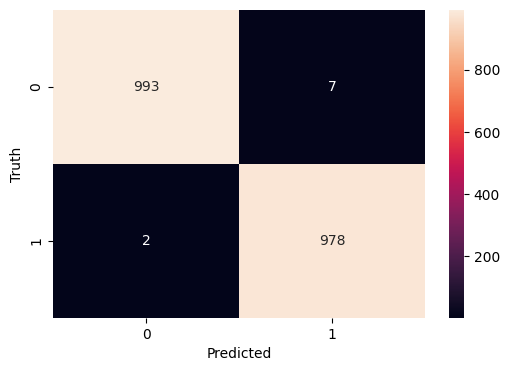

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')

#Exercise

- In this exercise, you are going to classify whether a given text belongs to one of possible classes ['BUSINESS', 'SPORTS', 'CRIME'].

- we are going to use spacy for pre-processing the text, convert text to numbers and apply different classification algorithms.



---
**About Data: News Category Classifier**

Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65

- This data consists of two columns. - Text - Category
- we have classes mainly of 'BUSINESS', 'SPORTS', 'CRIME' and comes under Multi-class classification Problem.


In [ ]:
#import spacy and loading the language model which we already download in above cell
import spacy

nlp = spacy.load('en_core_web_lg')

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
#import pandas library
import pandas as pd

#read the dataset "news_dataset.json" provided and load it into dataframe "df"
df = pd.read_json('/content/news_dataset.json')

#print the shape of data
print(df.shape)

#print the top5 rows
df.head()

(7500, 2)


,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS
3,This Richard Sherman Interception Literally Sh...,SPORTS
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS


In [ ]:
#check the distribution of labels
df['category'].value_counts()

,count
category,
CRIME,2500
SPORTS,2500
BUSINESS,2500


So dataset have equally distributed in all three categories means we have balanced dataset so we don't need to preform balanced dataset techniques likes oversampling (SMOTE), undersampling etc.

In [ ]:
#Add the new column "label_num" which gives a unique number to each of these labels
df['label_num'] = df['category'].map({
    'CRIME': 0,
    'SPORTS': 1,
    'BUSINESS': 2
})

#check the results with top 5 rows
df.head()

,text,category,label_num
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1
3,This Richard Sherman Interception Literally Sh...,SPORTS,1
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2


#Pre-Processing

In [ ]:
#use this utility function to preprocess the text
#1. Remove the stop words
#2. Convert to base form using lemmatisation

def preprocess(text):
  doc = nlp(text)
  filtered_tokens = []

  for token in doc:
    if token.is_stop or token.is_punct:
      continue
    filtered_tokens.append(token.lemma_)

  return " ".join(filtered_tokens)

In [ ]:
#create a new column "preprocessed_text" which store the clean form of given text [use apply and lambda function]
df['preprocessed_text'] = df['text'].apply(lambda x: preprocess(x))

In [ ]:
#print the top 5 rows
df.head()

,text,category,label_num,preprocessed_text
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame victim say victimize newly ...
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,vegas taxpayer spend Record $ 750 million New ...
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill Weed Legalization Buzz


#Get the spacy embeddings for each preprocessed text

In [ ]:
#create a new column "vector" that store the vector representation of each pre-processed text
df['vector'] = df['preprocessed_text'].apply(lambda x: nlp(x).vector)

In [ ]:
#print the top 5 rows
df.head()

,text,category,label_num,preprocessed_text,vector
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,0,Larry Nassar blame victim say victimize newly ...,"[-0.5585511, -0.29323253, -0.9253956, 0.189389..."
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,0,woman Beats Cancer die fall horse,"[-0.73039824, -0.43196002, -1.2930516, -1.0628..."
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,1,vegas taxpayer spend Record $ 750 million New ...,"[-1.9413117, 0.121578515, -3.2996283, 1.511650..."
3,This Richard Sherman Interception Literally Sh...,SPORTS,1,Richard Sherman Interception literally shake W...,"[-1.4702771, -0.685319, 0.57398, -0.31135806, ..."
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,2,7 thing totally kill Weed Legalization Buzz,"[-1.037173, -1.9495698, -1.7179357, 1.2975286,..."


#Splitting Dataset


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['vector'], df['label_num'], test_size=0.2, random_state=42, stratify=df['label_num'])

In [ ]:
# import numpy as np
import numpy as np

#reshapes the X_train and X_test using 'stack' function of numpy. Store the result in new variables "X_train_2d" and "X_test_2d"
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [ ]:
X_train_2d

array([[-0.9258801 ,  0.5142549 , -3.2380319 , ...,  0.62849003,
        -1.6211491 ,  0.89829   ],
       [-1.0321372 , -0.54102147, -0.44452137, ..., -1.6569573 ,
        -1.1806076 ,  0.7800115 ],
       [-1.4348997 , -1.410743  , -0.82139724, ..., -0.5879298 ,
         0.53662056,  0.31259766],
       ...,
       [-1.1692715 , -0.49880716,  0.01474715, ..., -0.7455472 ,
        -1.1485001 ,  1.524143  ],
       [-0.41674894,  0.1751208 ,  0.02985699, ...,  0.59855235,
        -1.3071404 ,  0.53069586],
       [-1.100425  , -2.37872   , -2.2773452 , ..., -1.83987   ,
        -1.3989899 ,  2.3874002 ]], dtype=float32)

here we can see these values are in negative so we need to do scaling on dataset before training the model but attempt 1 we are not going to do let's see the results.

**Attempt 1:**

- use spacy glove embeddings for text vectorization.

- use **Decision Tree** as the classifier.

- print the classification report.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

#1. creating a Decision Tree model object
clf = DecisionTreeClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       500
           1       0.70      0.68      0.69       500
           2       0.71      0.74      0.72       500

    accuracy                           0.71      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.71      0.71      1500



**Attempt 2:**

- use spacy glove embeddings for text vectorization.
- use **MultinomialNB** as the classifier after applying the **MinMaxscaler**.
- print the classification report.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

#doing scaling because Negative values will not pass into Naive Bayes models
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

#1. creating a MultinomialNB model object
clf = MultinomialNB()

#2. fit with all_train_embeddings(scaled) and y_train
clf.fit(X_train_scaled, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_scaled)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       500
           1       0.82      0.80      0.81       500
           2       0.78      0.81      0.79       500

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500



**Attempt 3:**

- use spacy glove embeddings for text vectorization.
- use **KNeighborsClassifier** as the classifier after applying the **MinMaxscaler**.
- print the classification report.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_scaled, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_scaled)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       500
           1       0.90      0.83      0.86       500
           2       0.89      0.86      0.87       500

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



**Attempt 4:**

- use spacy glove embeddings for text vectorization.
- use **RandomForestClassifier** as the classifier after applying the **MinMaxscaler**.
- print the classification report.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#1. creating a Random Forest model object
clf = RandomForestClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_scaled, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_scaled)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       500
           1       0.87      0.86      0.86       500
           2       0.87      0.86      0.87       500

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



**Attempt 5:**

- use spacy glove embeddings for text vectorization.
- use **GradientBoostingClassifier** as the classifier after applying the **MinMaxscaler**.
- print the classification report.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_scaled, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_scaled)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       500
           1       0.89      0.89      0.89       500
           2       0.88      0.89      0.88       500

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



#Confusion Matrix

In [ ]:
#finally print the confusion matrix for the best model: GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[443,  29,  28],
       [ 23, 445,  32],
       [ 28,  28, 444]])

Text(45.722222222222214, 0.5, 'Truth')

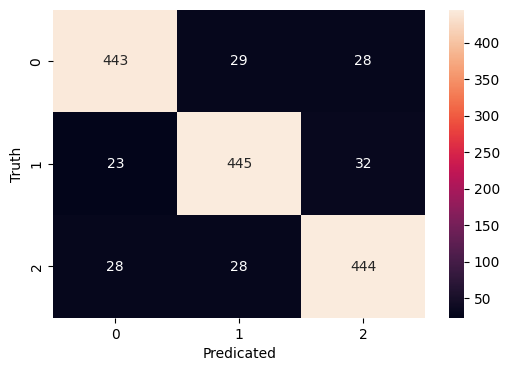

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicated')
plt.ylabel('Truth')